### <center>Universidad Autónoma de Nuevo León</center>
# <center>Supplier evaluation and selection in NPI process using a fuzzy logic model</center>
#### <center>Saúl R. Morales <a href="https://orcid.org/0000-0002-1120-7141"><img src="/orcid_logo.png" width="20" height="20"></a> © 2025</center>

This Jupyter Notebook contains the code used for the implementation of the fuzzy logic model in the my thesis for master's degree in Logistics and Supply Chain.

### Module import
In this code section the required modules are imported:
* __*date*__ to create a simulated NPI project. `Project`class requires milestone dates in `Date` class (format).
* __*matplotlib*__ to plot the fuzzy functions.
* __*numpy*__ to work with values in fuzzy variables.
* __*simulation*__ is a custom module with the required classes to simulate the NPI Sourcing process. The code can be found in `simulation.py`.
* __*skfuzzy*__ is a fuzzy logic framework for Python.

In [ ]:
pip install dotenv
pip install scikit-fuzzy
pip install openpyxl

In [1]:
from datetime import date
from math import ceil, floor
from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import simulation
import skfuzzy as fuzzy
import threading

### 1.1. Generate sample suppliers
Based in fuzzy variables (delivery time, quotation time, price, punctuality) and their values (low, regular, high), it will be necessary to generate 81 suppliers with different profiles each one, aiming to obtain a initial data frame with unbiased data.
Supplier/profile quantity is calculated as follows in this formula: $`R_{max} = \prod_{i=1}^{n} m_{i} = \prod_{i=1}^{4} 3 = 3^{4} = 81`$

The generated suppliers will be named as Supplier 1, Supplier 2, …, Supplier 81; however, from this list of 81 suppliers, three of them containing the profile of the current real-world suppliers will be named different to easily identify them (see table below).

| Supplier ID | Supplier name | Delivery time | Quotation time | Price | Punctuality |
|:-----------:|---------------|:-------------:|:--------------:|:-----:|:-----------:|
| 10000033 | Tuberías ABC, S.A. de C.V. | regular | low | regular | high|
| 10000047 | Tuberías DEF, S. de R.L. | regular | high | low | regular |
| 10000073 | Tuberías GHI, S.A.S. | high | high | low | low |

## 1. Training dataset
In this section a simulated dataset will be generated based in real-world statistics to determine the fuzzy functions of the model in [Section 2](#2.-Fuzzy-model-implementation).

**Table of contents**

[1.1. Generate sample suppliers](#1.1.-Generate-sample-suppliers)

[1.2. Create project and ECNs](#1.2.-Create-project-and-ECNs)

[1.3. Generating data frame](#1.3.-Generating-data-frame)

In [2]:
env = simulation.Environment()  # Initialize environment for the simulation.

current_supplier_names = ("Tuberías ABC, S.A. de C.V.", "Tuberías DEF, S. de R.L.", "Tuberías GHI, S.A.S.")
current_Supplier_ids = []
current_supplier_profile = (("regular", "low", "regular", "high"), ("regular", "high", "low", "regular"), ("high", "high", "low", "low"))

for delivery_time in ["low", "regular", "high"]:
    for quotation_time in ["low", "regular", "high"]:
        for price in ["low", "regular", "high"]:
            for punctuality in ["low", "regular", "high"]:
                if (delivery_time, quotation_time, price, punctuality) in current_supplier_profile:
                    supplier_index = current_supplier_profile.index((delivery_time, quotation_time, price, punctuality))
                    supplier_name = current_supplier_names[supplier_index]
                    supplier_id = f"1{str(simulation.Supplier.instances + 1).zfill(7)}"
                    print(f"{supplier_name} has ID {supplier_id}.")
                    current_Supplier_ids.append(supplier_id)
                else:
                    supplier_name = f"Supplier {simulation.Supplier.instances + 1}"   # Generate a supplier name concatenating Supplier and supplier number.

                supplier = simulation.Supplier(supplier_name, delivery_time, quotation_time, price, punctuality)
                env.add_supplier(supplier)  # Add supplier to simulation environment.

supplier_b = env.get_supplier("id", "10000033")
supplier_m = env.get_supplier("id", "10000047")
supplier_h = env.get_supplier("id", "10000073")

supplier_b.standard_lead_time = 30
supplier_m.standard_lead_time = 14
supplier_h.standard_lead_time = 28

Tuberías ABC, S.A. de C.V. has ID 10000033.
Tuberías DEF, S. de R.L. has ID 10000047.
Tuberías GHI, S.A.S. has ID 10000073.


### 1.2. Create project and ECNs
Create two sample projects named *Alaska* and *Pandora*.
It is important to define the milestone dates for these projectss. Required milestone dates are:
* **Design freeze (DF):** Restrict not important changes to the design of the project. Most of ECNs (Engineering Change Notification) are released near this date.
* **MCS:** I do not remember what does it stands for in this moment. In this stage a prototype containing the exact sourced material for the project to review to review their feasibility and adjust parameters in case it is needed. In this stage, part numbers do not need to be PPAP approved and built units cannot be sold.
* **Pilot:** In this stage a small but significant quantity of units of the project are produced. It aims to test the whole manufacturing process. All the material needs to be PPAP approved in this stage. Pilot units may be sold under Marketing approval.
* **Start of production (SOP):** Project implementation. Suppliers need to be ready at least six weeks before this date, however, *supplier readiness* may be longer depending on material lead time.

A quantity of 300 ECNs is created for this initial data frame. Each ECN contains a variable quantity of part numbers of different kinds. The quantity and kinds are randomly generated taking into account real statistics.

The simulated part numbers are copper tubes. From a real data set it was determined six kinds three complexity degrees (low, medium, regular). Both parameters affect prices and quantities.

In [3]:
try:
    imported_df = pd.read_excel("./Entry_DataFrames/training_df.xlsx")
    env.import_training_df(imported_df)
    env.item_master["Supplier ID"] = env.item_master["Supplier ID"].apply(str)
    env.item_master["Quotation date"] = pd.to_datetime(env.item_master["Quotation date"]).dt.date
    imported_data = True
except:
    alaska = simulation.Project(
        name="Alaska",
        df_date=date(2024,5,10), 
        mcs_date=date(2024,7,15),
        pilot_date=date(2024,9,1), 
        sop_date=date(2025,1,27)
    )   # Create project Alaska.

    anchorage = simulation.Project(
        name="Anchorage",
        df_date=date(2024,11,11),
        mcs_date=date(2025,3,25),
        pilot_date=date(2025,5,30),
        sop_date=date(2025,7,14)
    )   # Create project Pandora.

    kodiak = simulation.Project(
        name="Kodiak",
        df_date=date(2025,8,19),
        mcs_date=date(2026,2,5),
        pilot_date=date(2026,4,23),
        sop_date=date(2026,6,26)
    )   # Create project Pandora.

    for project in [alaska, anchorage, kodiak]:
        env.gen_ecns(project, 100)
        env.quote_all_ecn_project_all_suppliers(project)

    threads_gen_df = []
    for project in [alaska, anchorage, kodiak]:
        thread = threading.Thread(target=env.gen_initial_item_master_df_project, args=(project,))
        threads_gen_df.append(thread)
    for thread in threads_gen_df: thread.start()
    for thread in threads_gen_df: thread.join()

    env.item_master.loc[env.item_master["Iteration"].isna(), "Iteration"] = 0
    imported_data = False
    
    env.item_master.to_excel("./Entry_DataFrames/training_df.xlsx")

### 1.3. Generating data frame
Generate the data frame is divided in two steps:
1. Quoting all the ECNs with all the suppliers. The simulation uses real statistical data to generate random dates and prices.
2. Implementing each ECN with random chosen suppliers. A uniform distribution is used to randomly chose the suppliers.

## 2. Fuzzy model implementation
### 2.1. Generate dataset for fuzzy model
In this section a new project and data frame containing 10 copper piping ECNs is generated to apply it with the 

In [4]:
juneau = simulation.Project(
    name="Juneau",
    df_date=date(2024,4,9),
    mcs_date=date(2024,6,17),
    pilot_date=date(2024,8,1),
    sop_date=date(2024,11,25)
)

juneau_ecns_df = pd.read_excel("./Entry_DataFrames/Juneau_ecns.xlsx")
juneau_ecns = env.import_ecns_from_df(juneau, juneau_ecns_df)

for supplier in env.suppliers:
    if supplier.id not in current_Supplier_ids:
        env.deactivate_supplier(supplier)


#### To include the new supplier execute next block:

In [5]:
supplier_s = simulation.Supplier("Tuberías Súper, S.A.P.I.", "low", "low", "low", "high")
env.add_supplier(supplier_s)

for ecn in juneau.ecns:
    for quotation in ecn.quotations:
        for supplier in [supplier_b, supplier_h, supplier_m, supplier_s]:
            for supplier_quotation in supplier.quotations:
                if supplier_quotation == quotation:
                    supplier.quotations.remove(quotation)
            if ecn in supplier.awarded_ecns:
                supplier.awarded_ecns.remove(ecn)
    ecn.quotations = []

    env.item_master = env.item_master[env.item_master["Project"] != "Juneau"]

### 2.2. Scenario 1: Active evaluation

In [ ]:
from datetime import datetime, timedelta

otd_sop = []
fuzzy_evaluation = pd.DataFrame(data=None, columns=["Iteration", "ECN", "Supplier ID", "New supplier", "Rule 1", "Rule 2", "Rule 3", "Rule 4", "Rule 5", "Rule 6", "Rule 7", "Rule 8", "Rule 9", "Rule 10", "Rule 11", "Rule 12", "Rule 13", "Rule 14", "Rule 15", "Rule 16", "Rule 17", "Rule 18", "Score", "Wait", "Implement", "Action"])
ecn_qty = len(juneau.ecns)

simulation_results = simulation.Item_Master().df

for run in range(100):
    implemented_ecns = 0
    ecn_dates = []
    for ecn in juneau_ecns:
        ecn_dates.append(ecn.ecn_date)

    clock = min(ecn_dates)
    initial_classification = True

    continue_simulation = True
    while continue_simulation:
        if initial_classification:
            for ecn in juneau.ecns:
                ecn.reset()
            initial_classification = False

        for ecn in juneau.ecns:
            match ecn.status:
                case "Under review":
                    if ecn.ecn_date == clock:
                        env.quote_ecn_all_suppliers(ecn)

                case "Engineering release":
                    if len(fuzzy_evaluation[(fuzzy_evaluation["Iteration"] == run + 1) & (fuzzy_evaluation["ECN"] == ecn.ecn_id)]) == len(env.active_suppliers):
                        max_score = fuzzy_evaluation[(fuzzy_evaluation["Iteration"] == run + 1) & (fuzzy_evaluation["ECN"] == ecn.ecn_id)]["Score"].max()
                        max_score_supplier_df = fuzzy_evaluation[(fuzzy_evaluation["Iteration"] == run + 1) & (fuzzy_evaluation["ECN"] == ecn.ecn_id) & (fuzzy_evaluation["Score"] == max_score)]["Supplier ID"]

                        if len(max_score_supplier_df) > 1:
                            min_spend = env.item_master[(env.item_master["Supplier ID"].isin(max_score_supplier_df.to_list())) & (env.item_master["ECN"] == ecn.ecn_id)]["FY Spend"].min()
                            max_score_supplier_id = env.item_master[(env.item_master["ECN"] == ecn.ecn_id) & (env.item_master["FY Spend"] == min_spend)]["Supplier ID"].item()
                        else:
                            max_score_supplier_id = max_score_supplier_df.item()

                        max_score_supplier = env.get_supplier("id", max_score_supplier_id)
                        env.implement_ecn(ecn, max_score_supplier)
                        implemented_ecns += 1
                        #print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {max_score_supplier.name} awarded for {ecn.ecn_id} by desempate.")
                    
                    elif len(env.item_master[(env.item_master["ECN"] == ecn.ecn_id) & (env.item_master["Quotation date"] == clock)]["Supplier ID"].unique()) > 1:
                        for quotation in ecn.quotations:
                            if quotation.date == clock:
                                supplier_id = quotation.supplier.id

                                try:     
                                    evaluator = simulation.Fuzzy_Model(env.item_master, quotation.supplier, quotation.ecn, new_suppliers=False, imported_data=imported_data)
                                    stats = evaluator.get_stats()
                                except ZeroDivisionError:
                                    evaluator = simulation.Fuzzy_Model(env.item_master, quotation.supplier, quotation.ecn, new_suppliers=True, imported_data=imported_data)
                                    stats = evaluator.get_stats()
                                    
                                fuzzy_evaluation.loc[len(fuzzy_evaluation)] = [
                                    run + 1,
                                    ecn.ecn_id,
                                    stats["Supplier ID"],
                                    stats["New supplier"],
                                    stats["Rule 1"], stats["Rule 2"], stats["Rule 3"], stats["Rule 4"], stats["Rule 5"], stats["Rule 6"],
                                    stats["Rule 7"], stats["Rule 8"], stats["Rule 9"], stats["Rule 10"], stats["Rule 11"], stats["Rule 12"],
                                    stats["Rule 13"], stats["Rule 14"], stats["Rule 15"], stats["Rule 16"], stats["Rule 17"], stats["Rule 18"],
                                    stats["Score"],
                                    stats["Wait"],
                                    stats["Implement"],
                                    stats["Action"]
                                ]

                        max_score = fuzzy_evaluation[(fuzzy_evaluation["Iteration"] == run + 1) & (fuzzy_evaluation["ECN"] == ecn.ecn_id)]["Score"].max()
                        max_score_supplier_df = fuzzy_evaluation[(fuzzy_evaluation["Iteration"] == run + 1) & (fuzzy_evaluation["ECN"] == ecn.ecn_id) & (fuzzy_evaluation["Score"] == max_score)]["Supplier ID"]

                        if len(max_score_supplier_df) > 1:
                            min_spend = env.item_master[(env.item_master["Supplier ID"].isin(max_score_supplier_df.to_list())) & (env.item_master["ECN"] == ecn.ecn_id)]["FY Spend"].min()
                            max_score_supplier_id = env.item_master[(env.item_master["ECN"] == ecn.ecn_id) & (env.item_master["FY Spend"] == min_spend)]["Supplier ID"].item()
                        else:
                            max_score_supplier_id = max_score_supplier_df.item()

                        max_score_supplier = env.get_supplier("id", max_score_supplier_id)
                        env.implement_ecn(ecn, max_score_supplier)
                        implemented_ecns += 1
                        #print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {max_score_supplier.name} awarded for {ecn.ecn_id} by desempate.")
                    else:
                        for quotation in ecn.quotations:
                            if quotation.date == clock:
                                supplier_id = quotation.supplier.id
                                #print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {ecn.ecn_id} quotation received from {supplier_id}.")

                                try:     
                                    evaluator = simulation.Fuzzy_Model(env.item_master, quotation.supplier, quotation.ecn, new_suppliers=False, imported_data=imported_data)
                                    stats = evaluator.get_stats()
                                except ZeroDivisionError:
                                    evaluator = simulation.Fuzzy_Model(env.item_master, quotation.supplier, quotation.ecn, new_suppliers=True, imported_data=imported_data)
                                    stats = evaluator.get_stats()

                                fuzzy_evaluation.loc[len(fuzzy_evaluation)] = [
                                    run + 1,
                                    ecn.ecn_id,
                                    stats["Supplier ID"],
                                    stats["New supplier"],
                                    stats["Rule 1"], stats["Rule 2"], stats["Rule 3"], stats["Rule 4"], stats["Rule 5"], stats["Rule 6"],
                                    stats["Rule 7"], stats["Rule 8"], stats["Rule 9"], stats["Rule 10"], stats["Rule 11"], stats["Rule 12"],
                                    stats["Rule 13"], stats["Rule 14"], stats["Rule 15"], stats["Rule 16"], stats["Rule 17"], stats["Rule 18"],
                                    stats["Score"],
                                    stats["Wait"],
                                    stats["Implement"],
                                    stats["Action"]
                                ]
                                #print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {quotation.supplier.name} score is {stats['Score']}")

                                if stats["Action"] == "Implement":
                                    env.implement_ecn(ecn, quotation.supplier)
                                    implemented_ecns += 1
                                    #print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {quotation.supplier.name} awarded for {ecn.ecn_id}.")
                    
        if implemented_ecns == ecn_qty:
            continue_simulation = False
        else:
            clock += timedelta(days=1)

    otd = len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Awarded"] == True) & (env.item_master["SOP ready"] == True)]) / len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Awarded"] == True)])
    otd_sop.append(otd)

    for ecn in juneau.ecns:
        for quotation in ecn.quotations:
            for supplier in env.active_suppliers:
                for supplier_quotation in supplier.quotations:
                    if supplier_quotation == quotation:
                        supplier.quotations.remove(quotation)
                if ecn in supplier.awarded_ecns:
                    supplier.awarded_ecns.remove(ecn)
        ecn.quotations = []

    env.item_master.loc[env.item_master["Project"] == "Juneau", "Iteration"] = run + 1
    simulation_results = pd.concat([simulation_results, env.item_master[env.item_master["Project"] == "Juneau"]], ignore_index=True)

    env.item_master = env.item_master[env.item_master["Project"] != "Juneau"]

now = datetime.now().strftime("%d%m%Y%H%M%S")
simulation_results.to_excel(f"./Results/Implementation_results-{now}.xlsx")
fuzzy_evaluation.to_excel(f"./Results/Fuzzy_evaluation_results-{now}.xlsx")

mean(otd_sop)

### 2.3. Scenario 2: Strategic evaluation

## Define parameters for fuzzy variables

In [13]:
for ecn in juneau.ecns:
    env.quote_ecn_all_suppliers(ecn)

#juneau_df = env.item_master[env.item_master["Project"] == "Juneau"]
#juneau_df.to_excel("./Results/Scenario2_Juneau_quotations.xlsx")

/var/folders/ld/9nmqx_jj5fz968cfnx8mr3jw0000gn/T/ipykernel_43998/3547199719.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  µ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().mean())
/var/folders/ld/9nmqx_jj5fz968cfnx8mr3jw0000gn/T/ipykernel_43998/3547199719.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  σ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().std())
/var/folders/ld/9nmqx_jj5fz968cfnx8mr3jw0000gn/T/ipykernel_43998/3547199719.py:78: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rubusarbaro/Library/Python/3.11/lib/python/

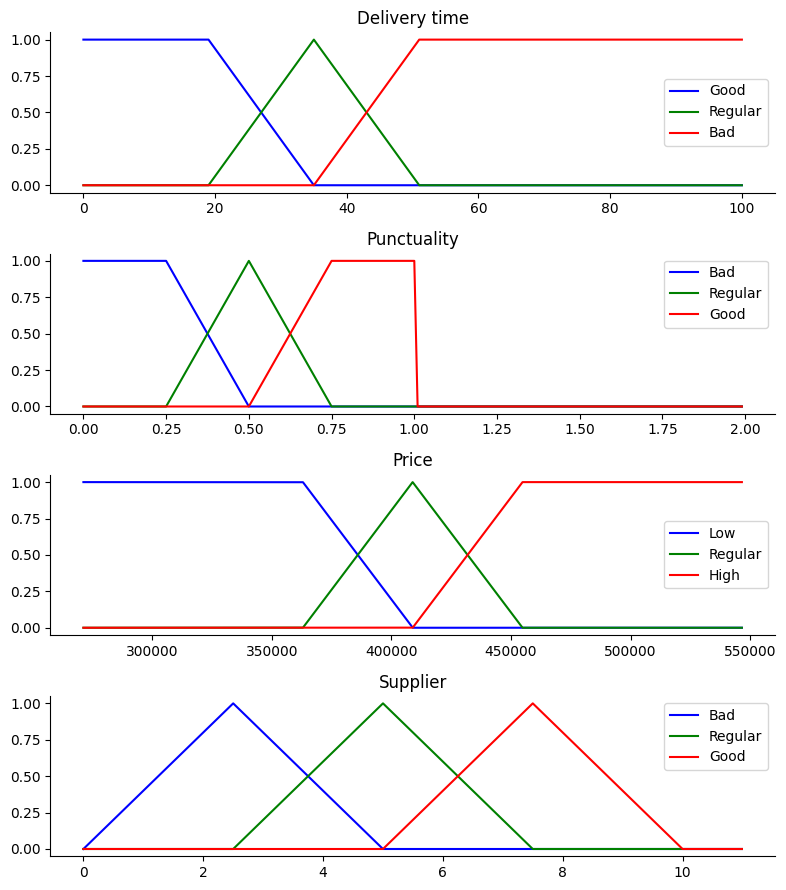

In [14]:
def get_µσ_punctuality(profile: str):
    punctuality_list = []

    for supplier_id in env.item_master[(env.item_master["Awarded"] == True) & (env.item_master["Delivery profile"] == profile)]["Supplier ID"].unique():
        punctuality = len(env.item_master[(env.item_master["Supplier ID"] == supplier_id) & (env.item_master["Awarded"] == True) & (env.item_master["OTD"] == True)]) / len(env.item_master[(env.item_master["Supplier ID"] == supplier_id) & (env.item_master["Awarded"] == True)])

        punctuality_list.append(punctuality)

    return (mean(punctuality_list), stdev(punctuality_list))

max_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].max())
max_quotation_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Quotation time"].max())
µ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().mean())
σ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().std())
min_business_total = max(µ_business_total - 3*σ_business_total, 0)
max_business_total = µ_business_total + 3*σ_business_total

var_delivery_time = np.arange(0, max_delivery_time + 1, 1)
var_price = np.arange(floor(µ_business_total - 3*σ_business_total), ceil(µ_business_total + 3*σ_business_total), 0.01)
var_punctuality = np.arange(0, 2, 0.01)
var_supplier = np.arange(0, 11, 0.01)

µ_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].mean())
σ_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].std())

µ_punctuality_low, σ_punctuality_low = get_μσ_punctuality("low")
µ_punctuality_medium, σ_punctuality_medium = get_μσ_punctuality("regular")
µ_punctuality_high, σ_punctuality_high = get_μσ_punctuality("high")

delivery_time_low = fuzzy.trapmf(var_delivery_time, [0, 0, µ_delivery_time - σ_delivery_time, µ_delivery_time])
delivery_time_medium = fuzzy.trimf(var_delivery_time, [µ_delivery_time - σ_delivery_time, µ_delivery_time, µ_delivery_time + σ_delivery_time])
delivery_time_high = fuzzy.trapmf(var_delivery_time, [µ_delivery_time, µ_delivery_time + σ_delivery_time, max_delivery_time, max_delivery_time])

punctuality_low = fuzzy.trapmf(var_punctuality, [0, 0, 0.25, 0.5])
punctuality_medium = fuzzy.trimf(var_punctuality, [0.25, 0.5, 0.75])
punctuality_high = fuzzy.trapmf(var_punctuality, [0.5, 0.75, 1, 1])

price_low = fuzzy.trapmf(var_price, [floor(min_business_total), floor(min_business_total), round(µ_business_total - σ_business_total), round(μ_business_total)])
price_medium = fuzzy.trimf(var_price, [round(μ_business_total - σ_business_total), round(μ_business_total), round(μ_business_total + σ_business_total)])
price_high = fuzzy.trapmf(var_price, [round(μ_business_total), round(μ_business_total + σ_business_total), ceil(max_business_total), ceil(max_business_total)])

supplier_low = fuzzy.trimf(var_supplier, [0, 2.5, 5])
supplier_medium = fuzzy.trimf(var_supplier, [2.5, 5, 7.5])
supplier_high = fuzzy.trimf(var_supplier, [5, 7.5, 10])

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(8, 9))

ax0.plot(var_delivery_time, delivery_time_low, "b", linewidth=1.5, label="Good")
ax0.plot(var_delivery_time, delivery_time_medium, "g", linewidth=1.5, label="Regular")
ax0.plot(var_delivery_time, delivery_time_high, "r", linewidth=1.5, label="Bad")
ax0.set_title("Delivery time")
ax0.legend()

ax1.plot(var_punctuality, punctuality_low, "b", linewidth=1.5, label="Bad")
ax1.plot(var_punctuality, punctuality_medium, "g", linewidth=1.5, label="Regular")
ax1.plot(var_punctuality, punctuality_high, "r", linewidth=1.5, label="Good")
ax1.set_title("Punctuality")
ax1.legend()

ax2.plot(var_price, price_low, "b", linewidth=1.5, label="Low")
ax2.plot(var_price, price_medium, "g", linewidth=1.5, label="Regular")
ax2.plot(var_price, price_high, "r", linewidth=1.5, label="High")
ax2.set_title("Price")
ax2.legend()

ax3.plot(var_supplier, supplier_low, "b", linewidth=1.5, label="Bad")
ax3.plot(var_supplier, supplier_medium, "g", linewidth=1.5, label="Regular")
ax3.plot(var_supplier, supplier_high, "r", linewidth=1.5, label="Good")
ax3.set_title("Supplier")
ax3.legend()

for ax in [ax0, ax1, ax2, ax3]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

In [ ]:
new_juneau_ecns = env.gen_ecns(juneau, 10)

In [ ]:
estrella = simulation.Supplier("Tuberías Súper, S.A.P.I.", "low", "low", "low", "high")
env.add_supplier(estrella)

In [ ]:
for ecn in juneau.ecns:
    env.quote_ecn_some_suppliers(ecn, [estrella])

In [ ]:
analyse_ecns = []

for ecn in new_juneau_ecns:
    analyse_ecns.append(ecn.ecn_id)

In [ ]:
env.item_master[env.item_master["Supplier ID"] == estrella.id]

In [ ]:
env.item_master.groupby(["ECN", "Supplier ID"])[["Price"]].sum().max()

### Price

**Low** (Average/Min/Max) **:** 165/34/296

**Regular** (Average/Min/Max) **:** 195/43/347

**High** (Average/Min/Max) **:** 232/51/413


In [ ]:
evaluation_supplier_id = "10000073"

crisp_delivery_time = env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True)]["Delivery time"].mean()
crisp_price = env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == evaluation_supplier_id)]["FY Spend"].sum()
#crisp_price = env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == evaluation_supplier_id) & env.item_master["ECN"].isin(analyse_ecns)]["FY Spend"].sum()
try:
    crisp_punctuality = len(env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True) & (env.item_master["OTD"] == True)]) / len(env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True)])
    new_supplier = False
except:
    new_supplier = True
    crisp_delivery_time = env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["ECN"].isin(juneau.ecns))]["Lead time"].mean()

# Assign membership degree
price_level_low = fuzzy.interp_membership(var_price, price_low, crisp_price)
price_level_medium = fuzzy.interp_membership(var_price, price_medium, crisp_price)
price_level_high = fuzzy.interp_membership(var_price, price_high, crisp_price)

if not new_supplier:
    punctuality_level_low = fuzzy.interp_membership(var_punctuality, punctuality_low, crisp_punctuality)
    punctuality_level_medium = fuzzy.interp_membership(var_punctuality, punctuality_medium, crisp_punctuality)
    punctuality_level_high = fuzzy.interp_membership(var_punctuality, punctuality_high, crisp_punctuality)

delivery_time_level_low = fuzzy.interp_membership(var_delivery_time, delivery_time_low, crisp_delivery_time)
delivery_time_level_medium = fuzzy.interp_membership(var_delivery_time, delivery_time_medium, crisp_delivery_time)
delivery_time_level_high = fuzzy.interp_membership(var_delivery_time, delivery_time_high, crisp_delivery_time)

# Rule application
# Example code uses np.fmax for OR operator. I will use np.fmin for AND.
if new_supplier:
    rule_1 = min(max(price_level_low, price_level_medium), delivery_time_level_low) # High

    rule_2 = min(max(price_level_low, price_level_medium), delivery_time_level_medium) # Regular

    rule_3 = min(max(price_level_low, price_level_medium), delivery_time_level_high) # Low

    rule_4 = price_level_high # Low

    low_strength = max(rule_3, rule_4)
    medium_strength = rule_2
    high_strength = rule_1
else:
    rule_1 = min(delivery_time_level_low, max(price_level_low, price_level_medium), punctuality_level_low)  # Regular

    rule_2 = min(delivery_time_level_low, max(price_level_low, price_level_medium), max(punctuality_level_medium, punctuality_level_high))  # High

    rule_3 = min(delivery_time_level_low, price_level_high, punctuality_level_low)  # Low

    rule_4 = min(delivery_time_level_low, price_level_high, max(punctuality_level_medium, punctuality_level_high))  # Regular

    rule_5 = min(delivery_time_level_medium, price_level_low, punctuality_level_low)    # Regular

    rule_6 = min(max(delivery_time_level_medium, delivery_time_level_high), max(price_level_low, price_level_medium), punctuality_level_medium) # Regular

    rule_7 = min(max(delivery_time_level_medium, delivery_time_level_high), max(price_level_low, price_level_medium), punctuality_level_high)   # High
    #rule_7 = min(delivery_time_level_medium, max(price_level_low, price_level_medium), punctuality_level_high)   # High

    rule_8 = min(delivery_time_level_medium, max(price_level_medium, price_level_high), punctuality_level_low)  # Low

    rule_9 = min(max(delivery_time_level_medium, delivery_time_level_high), price_level_high, punctuality_level_medium) # Low

    rule_10 = min(max(delivery_time_level_medium, delivery_time_level_high), price_level_high, punctuality_level_high)  # Medium

    rule_11 = min(delivery_time_level_high, punctuality_level_low)    # Low

    low_strength = max(rule_3, rule_8, rule_9, rule_11)
    medium_strength = max(rule_1, rule_4, rule_5, rule_6, rule_10)
    high_strength = max(rule_2, rule_7)

supplier_activation_low = np.fmin(low_strength, supplier_low)
supplier_activation_medium = np.fmin(medium_strength, supplier_medium)
supplier_activation_high = np.fmin(high_strength, supplier_high)

supplier_0 = np.zeros_like(var_supplier)

aggregated = np.fmax.reduce([supplier_activation_low, supplier_activation_medium, supplier_activation_high])


# Defuzzification
supplier_score = fuzzy.defuzz(var_supplier, aggregated, "centroid")
supplier_activation = fuzzy.interp_membership(var_supplier, aggregated, supplier_score)

fig, (ax5, ax6) = plt.subplots(nrows=2, figsize=(8, 9))

ax5.fill_between(var_supplier, supplier_0, supplier_activation_low, facecolor="b", alpha=0.7)
ax5.plot(var_supplier, supplier_low, "b", linewidth=0.5, linestyle="--")
ax5.fill_between(var_supplier, supplier_0, supplier_activation_medium, facecolor="g", alpha=0.7)
ax5.plot(var_supplier, supplier_medium, "g", linewidth=0.5, linestyle="--")
ax5.fill_between(var_supplier, supplier_0, supplier_activation_high, facecolor="r", alpha=0.7)
ax5.plot(var_supplier, supplier_high, "r", linewidth=0.5, linestyle="--")
ax5.set_title("Output membership")

ax6.plot(var_supplier, supplier_low, "b", linewidth=0.5, linestyle="--")
ax6.plot(var_supplier, supplier_medium, "g", linewidth=0.5, linestyle="--")
ax6.plot(var_supplier, supplier_high, "r", linewidth=0.5, linestyle="--")
ax6.fill_between(var_supplier, supplier_0, aggregated, facecolor="Orange", alpha=0.7)
ax6.plot([supplier_score, supplier_score], [0, supplier_activation], "k", linewidth=1.5, alpha=0.9)
ax6.set_title("Aggregated membership and supplier score (line)")

for ax in [ax5, ax6]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Supplier score: {supplier_score}")

print("Rules:")
for i, rule in enumerate([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10, rule_11]):
    print(f"Rule {i+1}: {rule:.3f}")

print("\nSupplier activations:")
print(f"Low: {supplier_activation_low.max():.3f}")
print(f"Medium: {supplier_activation_medium.max():.3f}")
print(f"High: {supplier_activation_high.max():.3f}")

print("\nCrisp values")
print(f"Average delivery time: {crisp_delivery_time}")
print(f"Total business cost: {crisp_price}")
print(f"Supplier punctuality: {crisp_punctuality}")

In [ ]:
env.item_master[(env.item_master["Awarded"] == True) & (env.item_master["Supplier ID"] == evaluation_supplier_id)]

In [ ]:
testing_supplier = env.get_supplier("id", "10000082")
otd_sop = []

for i in range(100):
    for ecn in juneau.ecns:
        env.implement_ecn(ecn, testing_supplier, overwrite=True)
    
    otd = len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == testing_supplier.id) & (env.item_master["Awarded"] == True) & (env.item_master["SOP ready"] == True)]) / len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == testing_supplier.id) & (env.item_master["Awarded"] == True)])

    otd_sop.append(otd)

mean(otd_sop)

## 3. Result analysis

### 3.1. Scenario 1

#### 3.1.1. Existing suppliers

In [ ]:
scenario1_existing_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(only_existent).xlsx")
scenario1_existing_supplier_item_master_df = scenario1_existing_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario1_existing_supplier_item_master_df[scenario1_existing_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "SOP ready"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#short_df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario1-1.xlsx")

In [ ]:
scenario1_existing_supplier_fuzzy_evaluation_df = pd.read_excel("./Results/Scenario1/Fuzzy_evaluation_results_(only_existent).xlsx")

In [ ]:
scenario1_existing_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(only_existent).xlsx")
scenario1_existing_supplier_item_master_df = scenario1_existing_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario1_existing_supplier_item_master_df[scenario1_existing_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "SOP ready"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#short_df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario1-1.xlsx")

supplier_otd = {
    "Supplier": [],
    "OTD": []
}

for supplier in short_df["Supplier name"].unique():

    otd_list = []
    for i in range(1,101):
        try:
            otd = len(short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier) & (short_df["SOP ready"] == True)]) / len(short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier)])
            otd_list.append(otd)
        except ZeroDivisionError:
            pass
    
    supplier_otd["Supplier"].append(supplier)
    supplier_otd["OTD"].append(stdev(otd_list))

pd.DataFrame(data=supplier_otd)

In [ ]:
scenario1_existing_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(only_existent).xlsx")
scenario1_existing_supplier_item_master_df = scenario1_existing_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario1_existing_supplier_item_master_df[scenario1_existing_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "FY Spend"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#short_df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario1-1.xlsx")

supplier_spend = {
    "Supplier": [],
    "Spend": []
}

for supplier in short_df["Supplier name"].unique():

    spend_list = []
    for i in range(1,101):
        spend = short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier)]["FY Spend"].sum()
        spend_list.append(spend)
    
    supplier_spend["Supplier"].append(supplier)
    supplier_spend["Spend"].append(stdev(spend_list))

pd.DataFrame(data=supplier_spend)

In [11]:
fuzzy_df = pd.read_excel("./Results/Scenario1/Fuzzy_evaluation_results_(only_existent).xlsx")
fuzzy_df = fuzzy_df.drop(["Unnamed: 0"], axis=1)

supplier_dict = {10000033: [], 10000047: [], 10000073: []}
supplier_df = {
    "Supplier": [],
    "Score avg": [],
    "Score std": []
}

for i in range(1,101):
    for supplier in supplier_dict.keys():
        i_df = fuzzy_df[(fuzzy_df["Iteration"] == i) & (fuzzy_df["Supplier ID"] == supplier)]

        supplier_df["Supplier"].append(supplier)
        supplier_df["Score avg"].append(mean(i_df["Implement"]))
        supplier_df["Score std"].append(stdev(i_df["Implement"]))

pd.DataFrame(data=supplier_df)

StatisticsError: stdev requires at least two data points

#### 3.1.2. New suppliers

In [ ]:
scenario1_new_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(including_new).xlsx")
scenario1_new_supplier_item_master_df = scenario1_new_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario1_new_supplier_item_master_df[scenario1_new_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "SOP ready"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#short_df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario1-2-2.xlsx")

In [ ]:
otd_list = []

for i in range(1,101):
    otd = len(short_df[(short_df["Iteration"] == i) & (short_df["SOP ready"] == True)]) / len(short_df[(short_df["Iteration"] == i)])
    otd_list.append(otd)

stdev(otd_list)

In [ ]:
scenario1_new_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(including_new).xlsx")
scenario1_new_supplier_item_master_df = scenario1_new_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario1_new_supplier_item_master_df[scenario1_new_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "FY Spend"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#short_df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario1-1.xlsx")

supplier_spend = {
    "Supplier": [],
    "Spend": []
}

for supplier in short_df["Supplier name"].unique():

    spend_list = []
    for i in range(1,101):
        spend = short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier)]["FY Spend"].sum()
        spend_list.append(spend)
    
    supplier_spend["Supplier"].append(supplier)
    supplier_spend["Spend"].append(stdev(spend_list))

pd.DataFrame(data=supplier_spend)#["Spend"].sum()

In [ ]:
spend_list = []

for i in range(1,101):
    spend = short_df[(short_df["Iteration"] == i)]["FY Spend"].sum()
    spend_list.append(spend)

stdev(spend_list)

### 3.2. Scenario 2

#### 3.2.1. Only existent suppliers

In [ ]:
scenario2_existing_supplier_item_master_df = pd.read_excel("./Results/Scenario1/Implementation_results_(only_existent).xlsx")
scenario2_existing_supplier_item_master_df = scenario2_existing_supplier_item_master_df.drop(["Unnamed: 0"], axis=1)

short_df = scenario2_existing_supplier_item_master_df[scenario2_existing_supplier_item_master_df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "SOP ready"]].drop_duplicates().reset_index().drop(["index"], axis=1)

supplier_otd = {
    "Supplier": [],
    "OTD mean": [],
    "OTD std": []
}

for supplier in short_df["Supplier name"].unique():

    otd_list = []
    for i in range(1,101):
        try:
            otd = len(short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier) & (short_df["SOP ready"] == True)]) / len(short_df[(short_df["Iteration"] == i) & (short_df["Supplier name"] == supplier)])
            otd_list.append(otd)
        except ZeroDivisionError:
            pass
    
    supplier_otd["Supplier"].append(supplier)
    supplier_otd["OTD mean"].append(mean(otd_list))
    supplier_otd["OTD std"].append(stdev(otd_list))

pd.DataFrame(data=supplier_otd)

In [ ]:
supplier_dict = {"Tuberías ABC, S.A. de C.V.": [], "Tuberías DEF, S. de R.L.": [], "Tuberías GHI, S.A.S.": [], "Tuberías Súper, S.A.P.I.": []}
supplier_df = {
    "Supplier": [],
    "ECN avg": [],
    "ECN std": []
}

for i in range(1,101):
    short_df = df[df["Iteration"] == i]

    for supplier in supplier_dict.keys():
        supplier_dict[supplier].append(len(short_df[short_df["Supplier name"] == supplier]))

for supplier in supplier_dict.keys():
    supplier_df["Supplier"].append(supplier)
    supplier_df["ECN avg"].append(mean(supplier_dict[supplier]))
    supplier_df["ECN std"].append(stdev(supplier_dict[supplier]))

pd.DataFrame(data=supplier_df)#["ECN std"].mean()

### 3.3. Comparison with other simulation methods

#### 3.3.1. Random uniform selection

In [ ]:
from datetime import datetime
from random import choice

otd_sop = []
# fuzzy_evaluation = pd.DataFrame(data=None, columns=["Iteration", "ECN", "Supplier ID", "New supplier", "Rule 1", "Rule 2", "Rule 3", "Rule 4", "Rule 5", "Rule 6", "Rule 7", "Rule 8", "Rule 9", "Rule 10", "Rule 11", "Rule 12", "Rule 13", "Rule 14", "Rule 15", "Rule 16", "Rule 17", "Rule 18", "Score", "Wait", "Implement", "Action"])  # Fuzzy evaluation will not be used in this comparison method.
ecn_qty = len(juneau.ecns)

simulation_results = simulation.Item_Master().df

for run in range(100):
    for ecn in juneau_ecns:
        ecn.reset()

        chosen_supplier = choice(env.active_suppliers)
        env.quote_ecn_some_suppliers(ecn,[chosen_supplier])
        env.implement_ecn(ecn, chosen_supplier)

    otd = len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Awarded"] == True) & (env.item_master["SOP ready"] == True)]) / len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Awarded"] == True)])
    otd_sop.append(otd)

    for ecn in juneau.ecns:
        for quotation in ecn.quotations:
            for supplier in env.active_suppliers:
                for supplier_quotation in supplier.quotations:
                    if supplier_quotation == quotation:
                        supplier.quotations.remove(quotation)
                if ecn in supplier.awarded_ecns:
                    supplier.awarded_ecns.remove(ecn)
        ecn.quotations = []

    env.item_master.loc[env.item_master["Project"] == "Juneau", "Iteration"] = run + 1
    simulation_results = pd.concat([simulation_results, env.item_master[env.item_master["Project"] == "Juneau"]], ignore_index=True)

    env.item_master = env.item_master[env.item_master["Project"] != "Juneau"]

now = datetime.now().strftime("%d%m%Y%H%M%S")
simulation_results.to_excel(f"./Results/Implementation_results-random_uniform-{now}.xlsx")

mean(otd_sop)

In [ ]:
df = pd.read_excel("./Results/Scenario1/Implementation_results-random_uniform-27102025215801.xlsx")
df = df.drop(["Unnamed: 0"], axis=1)
df = df.drop(["Unnamed: 0.1"], axis=1)

df = df[df["Awarded"] == True][["Iteration", "ECN", "Supplier name", "SOP ready"]].drop_duplicates().reset_index().drop(["index"], axis=1)
#df.groupby(["Iteration", "Supplier name"]).count()[["ECN"]].to_excel("ecn_qty_per_supplier_scenario_1-1_random_uniform.xlsx")
df

In [ ]:
supplier_dict = {"Tuberías ABC, S.A. de C.V.": [], "Tuberías DEF, S. de R.L.": [], "Tuberías GHI, S.A.S.": [], "Tuberías Súper, S.A.P.I.": []}
supplier_df = {
    "Supplier": [],
    "ECN avg": [],
    "ECN std": []
}

for i in range(1,101):
    short_df = df[df["Iteration"] == i]

    for supplier in supplier_dict.keys():
        supplier_dict[supplier].append(len(short_df[short_df["Supplier name"] == supplier]))

for supplier in supplier_dict.keys():
    supplier_df["Supplier"].append(supplier)
    supplier_df["ECN avg"].append(mean(supplier_dict[supplier]))
    supplier_df["ECN std"].append(stdev(supplier_dict[supplier]))

pd.DataFrame(data=supplier_df)#["ECN std"].mean()